In [1]:
import pandas as pd
import s3fs
from tqdm import tqdm
from joblib import Parallel, delayed
from pathlib import Path
import geopandas as gpd
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This notebook aims to generate the WIT plots after we finish the WIT Airflow DAG (https://github.com/GeoscienceAustralia/dea-airflow/blob/develop/dags/k8s_wit_tooling_conflux.py) running
# Assume we are using follow Airflow config to start Airflow DAG run
airflow_run_cfg = {
 "shapefile": "s3://dea-public-data-dev/projects/WIT/test_shp/C2_v4_NSW_only.shp",
 "intermediatedir": "s3://dea-public-data-dev/projects/WIT/C2_v4_NSW_only",
 "csvdir": "s3://dea-public-data-dev/projects/WIT/C2_v4_NSW_only_csv",
 "cmd": "'lat in [-36.006, -34.671] lon in [142.392, 144.496] gqa_mean_x in [-1, 1]'",
 "flags": "--overwrite"
}

csvdir = airflow_run_cfg['csvdir']
shapefile = airflow_run_cfg['shapefile']

In [3]:
def load_csv(csv_file_path):
    df = pd.read_csv("s3://" + csv_file_path)
    # add csv file path to debug
    df["s3_csv_path"] = csv_file_path
    if df.empty is True:
        return pd.DataFrame()
    return df

In [4]:
# Setup the AWS S3 access
fs = s3fs.S3FileSystem(anon=True)

# we need load the polygon file to access polygon human-readable information
polygons = gpd.read_file(shapefile)

# load the WIT result from Airflow DAG running output folder
conflux_c3_csv_files = fs.find(csvdir)

# ignore the debug.csv
conflux_c3_csv_files = [e for e in conflux_c3_csv_files if 'debug' not in e]

wit_dfs = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(load_csv)("s3://" + e ) for e in tqdm(conflux_c3_csv_files))

# make sure we clean data before display
wit_dfs = [e[e['pc_missing'] < 0.1] for e in wit_dfs]
wit_dfs = [e.dropna(subset=['bs']) for e in wit_dfs]

100%|██████████| 28/28 [00:04<00:00,  6.84it/s]


In [5]:
def generate_polygon_names(feature_id, polygons, df_size):
    # full of hard-code values which belong to this shape file
    # maybe just keep the simple version (feature_id.png) as PNG name in the future
    try:
        RAMSAR_NAM = polygons[polygons['FeatureID'] == feature_id].iloc[0]['RAMSAR_NAM']
        wetland_name = polygons[polygons['FeatureID'] == feature_id].iloc[0]['WETLAND_NA']
        png_name = f"{str(feature_id).zfill(3)}-{RAMSAR_NAM}-{wetland_name}"
        plot_title = f"{RAMSAR_NAM} {wetland_name} - ID {feature_id}: {df_size} scenes"
    except:
        png_name = str(feature_id)
        plot_title = f"ID {feature_id}: {df_size} scenes in C3"
    
    return plot_title, png_name


def display_wit_as_stack_plot(wit_df, polygons=None, png_folder_name="wit_png", width=30, height=5):
    
    # if we try to display an empty CSV, skip it
    if len(wit_df) == 0:
        return
    
    feature_id = list(wit_df['feature_id'])[-1]

    pal = ['#030aa7',
           '#04d9ff',
           '#3f9b0b',
           '#e6daa6',
           '#60460f']

    if len(wit_df) > 500:
        upscale = int(len(wit_df) // 15)
    else:
        upscale = int(len(wit_df) // 20)
        
    if upscale == 0:
        upscale = 1

    wit_df['display_time'] = [e.split("T")[0] for e in wit_df['date']]

    wit_xs = wit_df['display_time']
    wit_ys = wit_df[["water", "wet", "pv", "npv", "bs"]]
    wit_ys = wit_ys.clip(0, 1)

    fig = plt.figure()
    fig.set_size_inches(width, height)
    ax = fig.add_subplot(111)
    ax.autoscale(enable=True)

    plot_title, png_name = generate_polygon_names(feature_id, polygons, len(wit_df))

    plt.title(plot_title, fontsize=16)

    ax.stackplot(wit_xs, wit_ys["water"], wit_ys["wet"], wit_ys["pv"], wit_ys["npv"], wit_ys["bs"], colors=pal, alpha=0.6)

    ax.set_ylim(0, 1)
    ax.set_xlim(wit_xs.min(), wit_xs.max())

    xlabels = []

    for n,i in enumerate(wit_xs):
        if n%upscale==0:
            xlabels.append(i)
        else:
            xlabels.append('')

    ax.set_xticks(xlabels)

    ax.set_xlabel('Date')
    ax.set_ylabel("Fraction")


    plt.savefig(f"{png_folder_name}/{png_name}.png")
    plt.show()
    
    plt.close(fig)

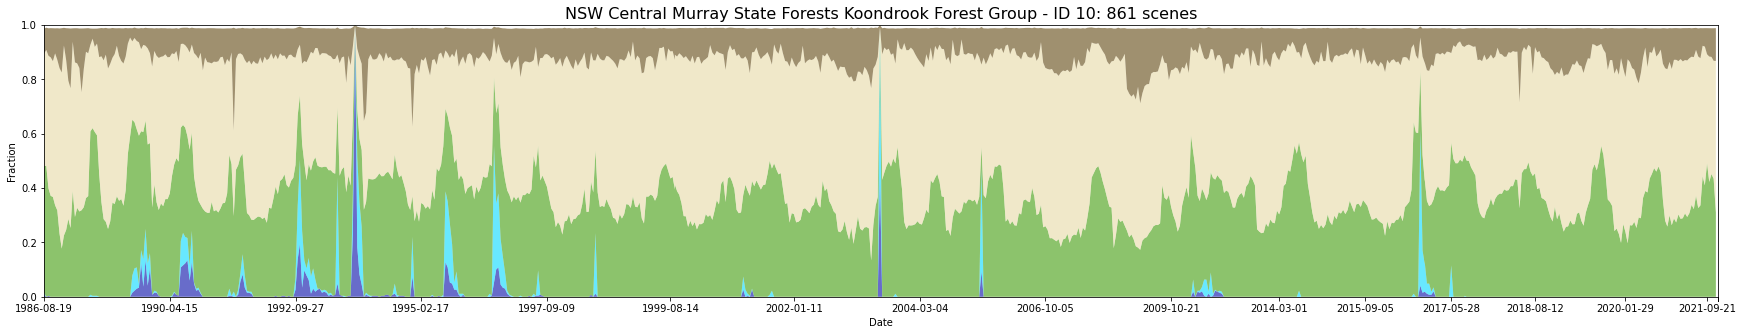

In [6]:
png_folder_name = "wit_png"

Path(png_folder_name).mkdir(exist_ok=True)

# Only display the first one to make it display well
for wit_df in wit_dfs[:1]:
    display_wit_as_stack_plot(wit_df, polygons, png_folder_name)